# Network and Spatial Analysis
#### Author: Nathan Seiler

## 0. Import Necessary Packages

In [135]:
import geopandas as gpd
import pandas as pd
import numpy as np

import datetime

import osmnx as ox
import networkx as nx

import pulp
from pulp import *

from scipy.spatial.distance import cdist
import libpysal as ps
import matplotlib.pyplot as plt

from descartes import PolygonPatch
from shapely.geometry import Point, LineString, MultiLineString, Polygon

## 1. Import Data

In [277]:
# health inspection data
inspections = pd.read_csv('./data/inspections_data_18_22.csv')
# Chicago communities shapefile with population data included
chi_comm_pop = gpd.read_file('./data/chicago_comm_pop/chicago_comm_pop.shp')
# Chicago communities with geometry
chi_comm_geo = gpd.read_file('./data/chicomm/chicomm.shp')

### Grab and store coordinates of Chicago Departments of Public Health

In [278]:
cdph_lexingtonSt_coord = (41.87542275191835, -87.68051207654261)
cdph_clarkSt_coord = (41.935522673089785, -87.6459566691358)
cdph_89thSt_coord = (41.735179944870914, -87.55193771223088)
cdph_austinBlvd_coord = (41.90506981214823, -87.74986326738333)
cdph_stateSt_coord = (41.87821750700417, -87.62722948524276)

*Source: Google Maps*

## 2. Clean and Merge Datasets

In [279]:
# location column is hot garbage so get rid of it
inspections = inspections.drop(columns=['Location'])

In [280]:
# let's make it look like a real geodataframe and spatially reference the geometry 
inspections = gpd.GeoDataFrame(
    inspections, geometry=gpd.points_from_xy(inspections.Latitude, inspections.Longitude))

inspections = inspections.drop(columns=['Latitude', 'Longitude'])
inspections = inspections.set_crs('epsg:4269')

In [281]:
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,geometry
0,2129828,CHICAGO PIZZA & OVEN GRINDER,CHICAGO PIZZA & OVEN GRINDER,28176.0,Restaurant,Risk 1 (High),2121 N CLARK ST,CHICAGO,IL,60614.0,1/2/2018,Complaint,No Entry,NaN,POINT (41.92081 -87.63742)
1,2129833,CHIPOTLE MEXICAN GRILL,CHIPOTLE MEXICAN GRILL,76582.0,Restaurant,Risk 1 (High),2256 N ORCHARD ST,CHICAGO,IL,60614.0,1/2/2018,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,POINT (41.92352 -87.64642)
2,2129829,FORK,FORK,1276082.0,Restaurant,Risk 1 (High),4600-4602 N LINCOLN AVE,CHICAGO,IL,60625.0,1/2/2018,Complaint,No Entry,NaN,POINT (41.96490 -87.68628)
3,2129836,JIMMY JOHNS SANDWICH SHOPS,JIMMY JOHNS SANDWICH SHOPS,1695167.0,Restaurant,Risk 1 (High),2029 W DIVISION ST,CHICAGO,IL,60622.0,1/2/2018,Canvass,Pass w/ Conditions,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...,POINT (41.90306 -87.67844)
4,2129832,MORSE FRESH MARKET,MORSE FRESH MARKET,1518304.0,Grocery Store,Risk 1 (High),1430 W MORSE AVE,CHICAGO,IL,60626.0,1/2/2018,Canvass Re-Inspection,Fail,29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42...,POINT (42.00799 -87.66717)


### Remove Unnecessary Columns

In [284]:
inspections_clean = inspections.drop(columns=['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type', 'City', 'State', 'Zip', 'Results', 'Violations'])

In [285]:
inspections_clean.head()

,Risk,Address,Inspection Date,Inspection Type,geometry
0,Risk 1 (High),2121 N CLARK ST,1/2/2018,Complaint,POINT (41.92081 -87.63742)
1,Risk 1 (High),2256 N ORCHARD ST,1/2/2018,Canvass,POINT (41.92352 -87.64642)
2,Risk 1 (High),4600-4602 N LINCOLN AVE,1/2/2018,Complaint,POINT (41.96490 -87.68628)
3,Risk 1 (High),2029 W DIVISION ST,1/2/2018,Canvass,POINT (41.90306 -87.67844)
4,Risk 1 (High),1430 W MORSE AVE,1/2/2018,Canvass Re-Inspection,POINT (42.00799 -87.66717)


### Reformatting the 'Inspection Date' Column

In [286]:
type(inspections_clean['Inspection Date'][0])

str

In [287]:
inspections_clean['year'] = pd.DatetimeIndex(inspections_clean['Inspection Date']).year
inspections_clean['month'] = pd.DatetimeIndex(inspections_clean['Inspection Date']).month
inspections_clean['day'] = pd.DatetimeIndex(inspections_clean['Inspection Date']).day
inspections_clean.head()

,Risk,Address,Inspection Date,Inspection Type,geometry,year,month,day
0,Risk 1 (High),2121 N CLARK ST,1/2/2018,Complaint,POINT (41.92081 -87.63742),2018,1,2
1,Risk 1 (High),2256 N ORCHARD ST,1/2/2018,Canvass,POINT (41.92352 -87.64642),2018,1,2
2,Risk 1 (High),4600-4602 N LINCOLN AVE,1/2/2018,Complaint,POINT (41.96490 -87.68628),2018,1,2
3,Risk 1 (High),2029 W DIVISION ST,1/2/2018,Canvass,POINT (41.90306 -87.67844),2018,1,2
4,Risk 1 (High),1430 W MORSE AVE,1/2/2018,Canvass Re-Inspection,POINT (42.00799 -87.66717),2018,1,2


In [288]:
type(inspections_clean['year'][0])

numpy.int64

In [289]:
inspections_clean = inspections_clean.drop(columns = ['Inspection Date'])
inspections_clean.head()

,Risk,Address,Inspection Type,geometry,year,month,day
0,Risk 1 (High),2121 N CLARK ST,Complaint,POINT (41.92081 -87.63742),2018,1,2
1,Risk 1 (High),2256 N ORCHARD ST,Canvass,POINT (41.92352 -87.64642),2018,1,2
2,Risk 1 (High),4600-4602 N LINCOLN AVE,Complaint,POINT (41.96490 -87.68628),2018,1,2
3,Risk 1 (High),2029 W DIVISION ST,Canvass,POINT (41.90306 -87.67844),2018,1,2
4,Risk 1 (High),1430 W MORSE AVE,Canvass Re-Inspection,POINT (42.00799 -87.66717),2018,1,2


## 3. Create the network graph

In [259]:
# we need to add the restaurants as nodes but we also need it to not take forever...


# select month and year 
month = ''

# 2018 - 2022
year = ''

# add inspection nodes to graph
# well shoot, i can't just add one commmunity area because there isn't a health department in every community area.
# to graph the new
# select community area
community_names = list(chi_comm_geo['DISTITLE'].unique())
print(community_names)

community_area_name = ''
community_area = f'{community_area_name}, Chicago, Illinois'

['Burnside', 'Riverdale', 'Rogers Park', 'West Ridge', 'Uptown', 'Lincoln Square', 'North Center', 'Lake View', 'Lincoln Park', 'Edison Park', 'Jefferson Park', 'Forest Glen', 'North Park', 'Albany Park', 'Portage Park', 'Irving Park', 'Dunning', 'Montclare', 'Belmont Cragin', 'Hermosa', 'Avondale', 'Logan Square', 'Humboldt Park', 'West Town', 'Near North Side', 'Austin', 'West Garfield Park', 'East Garfield Park', 'Near West Side', 'North Lawndale', 'South Lawndale', 'Lower West Side', 'Loop', 'Near South Side', 'Armour Square', 'Douglas', 'Oakland', 'Fuller Park', 'Grand Boulevard', 'Kenwood', 'Washington Park', 'Hyde Park', 'Woodlawn', 'South Shore', 'Chatham', 'Avalon Park', 'South Chicago', 'Calumet Heights', 'Roseland', 'Pullman', 'South Deering', 'East Side', 'Hegewisch', 'West Pullman', 'Garfield Ridge', 'Archer Heights', 'Brighton Park', 'McKinley Park', 'Bridgeport', 'New City', 'West Elsdon', 'West Lawn', 'Chicago Lawn', 'West Englewood', 'Englewood', 'Greater Grand Crossin

In [242]:
near_west_side = ox.graph_from_place('Near West Side, Chicago, Illinois', network_type = 'drive', simplify = True)

In [243]:
origin_node = ox.get_nearest_node(near_west_side, cdph_lexingtonSt_coord)
destination_node = ox.get_nearest_node(near_west_side, (42.01219,-87.67472))

/opt/anaconda3/lib/python3.8/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.8/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [244]:
a_star_route = nx.astar_path(near_west_side, origin_node, destination_node, weight="length")

In [245]:
near_west_side = ox.add_edge_speeds(near_west_side)

# calculate travel time (seconds) for all edges
near_west_side = ox.add_edge_travel_times(near_west_side)

edges = ox.graph_to_gdfs(near_west_side, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
motorway,328.9,82.1,14.2
motorway_link,290.2,88.5,11.8
primary,98.4,66.8,5.3
primary_link,62.5,66.8,3.4
residential,112.0,66.8,6.0
road,28.2,66.8,1.5
secondary,118.7,48.3,8.9
secondary_link,49.4,66.8,2.7
tertiary,107.5,48.3,8.0


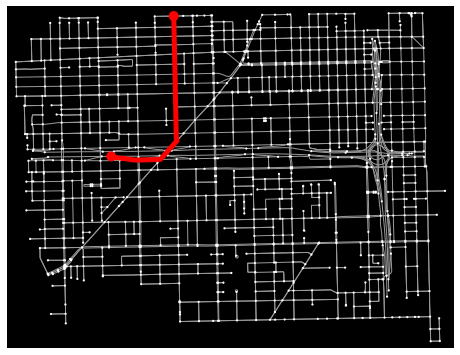

In [246]:
fig, ax = ox.plot_graph_route(near_west_side, a_star_route, route_linewidth=5, node_size=5, bgcolor='k', route_alpha=1)

In [247]:
dijstra_route_time=nx.dijkstra_path(near_west_side, origin_node, destination_node, weight="travel_time")

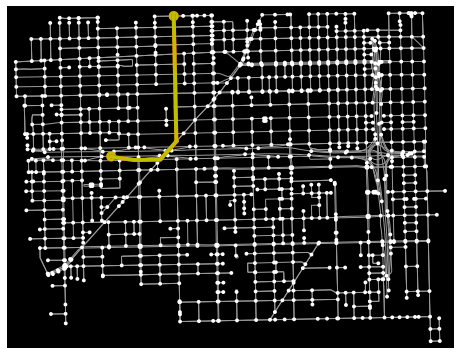

In [248]:
fig, ax = ox.plot_graph_routes(near_west_side, routes=[a_star_route,dijstra_route_time], route_colors=['r', 'y'], bgcolor='k', route_alpha=1)

In [249]:
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch


trip_times = [2*60, 3*60, 5*60] #in seconds

iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

isochrone_polys = []


for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(near_west_side, origin_node, radius=trip_time, distance='travel_time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

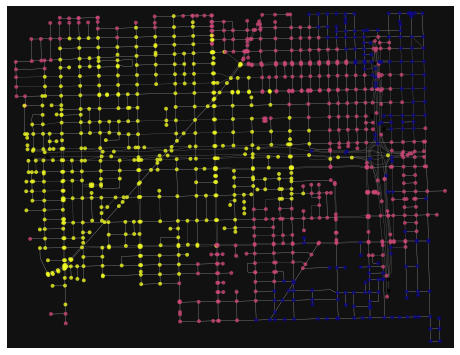

In [250]:
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(near_west_side, origin_node, radius=trip_time, distance='travel_time')
    for node in subgraph.nodes():
        node_colors[node] = color
        
nc = [node_colors[node] if node in node_colors else 'none' for node in near_west_side.nodes()]
fig, ax = ox.plot_graph(near_west_side, node_color=nc, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='#999999')

### Removing unnecessary nodes

Removed 359 nodes (0.0360%) from the OSMNX network
Number of nodes: 9974
Number of edges: 18859


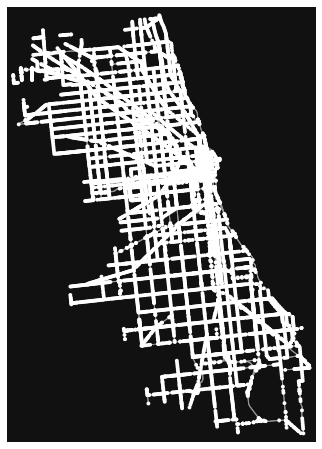

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [252]:
def remove_uncenessary_nodes(network):
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg == 0])
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg == 0])
    for component in list(nx.strongly_connected_components(network)):
        if len(component) < 10:
            for node in component:
                _nodes_removed += 1
                network.remove_node(node)

    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed / float(network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))

    return network


# Obtain OSM Network for the correct community_area
G = ox.graph_from_place('Chicago, Illinois', network_type='drive', simplify=True)

# Simplify Graph: Remove edges
for u, v, data in G.copy().edges(data=True):
    if data['highway'] not in ['motorway', 'motorway_link', 
                               'trunk', 'trunk_link',
                               'primary', 'primary_link', 
# This line is commented to make the future process faster. 
# If your study area is small and doesn't have enough road network, please uncomment the following line. 
                                'secondary', 'secondary_link'  
                              ]:
        G.remove_edge(u, v)
        
# Simplify Graph: Remove nodes
G.remove_nodes_from(list(nx.isolates(G)))

G = ox.project_graph(G, to_crs='epsg:5070')
G = remove_uncenessary_nodes(G)

%%time
ox.plot_graph(G)

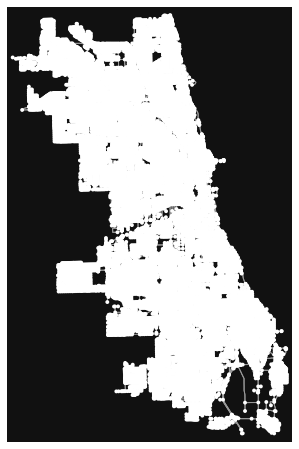

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [253]:
%%time

chicago = ox.graph_from_place('Chicago, Illinois', network_type='drive', simplify=True)
ox.plot_graph(chicago)

## 4. Spatial Optimization using the P-median Problem

Let's say we would like to place a number *P* of facilities while minimizing the total weighted distance of servicing all demands. Each node has an associated weight that represents the amount of demand at that nodes, we will use population because a health department is an important community resource. 

**Objective function:** Minimizing demand-weighted summed over all facilities and demand nodes.

**Decision variables:** where to put the facilities and which demand nodes are serviced by which facility location 

**Constraints:**
- Each node is serviced by 1 facility
- A node can be serviced by a facility at a certain location only if there is a facility.
- We must place p facilities
- Each node is either a facility or not. 

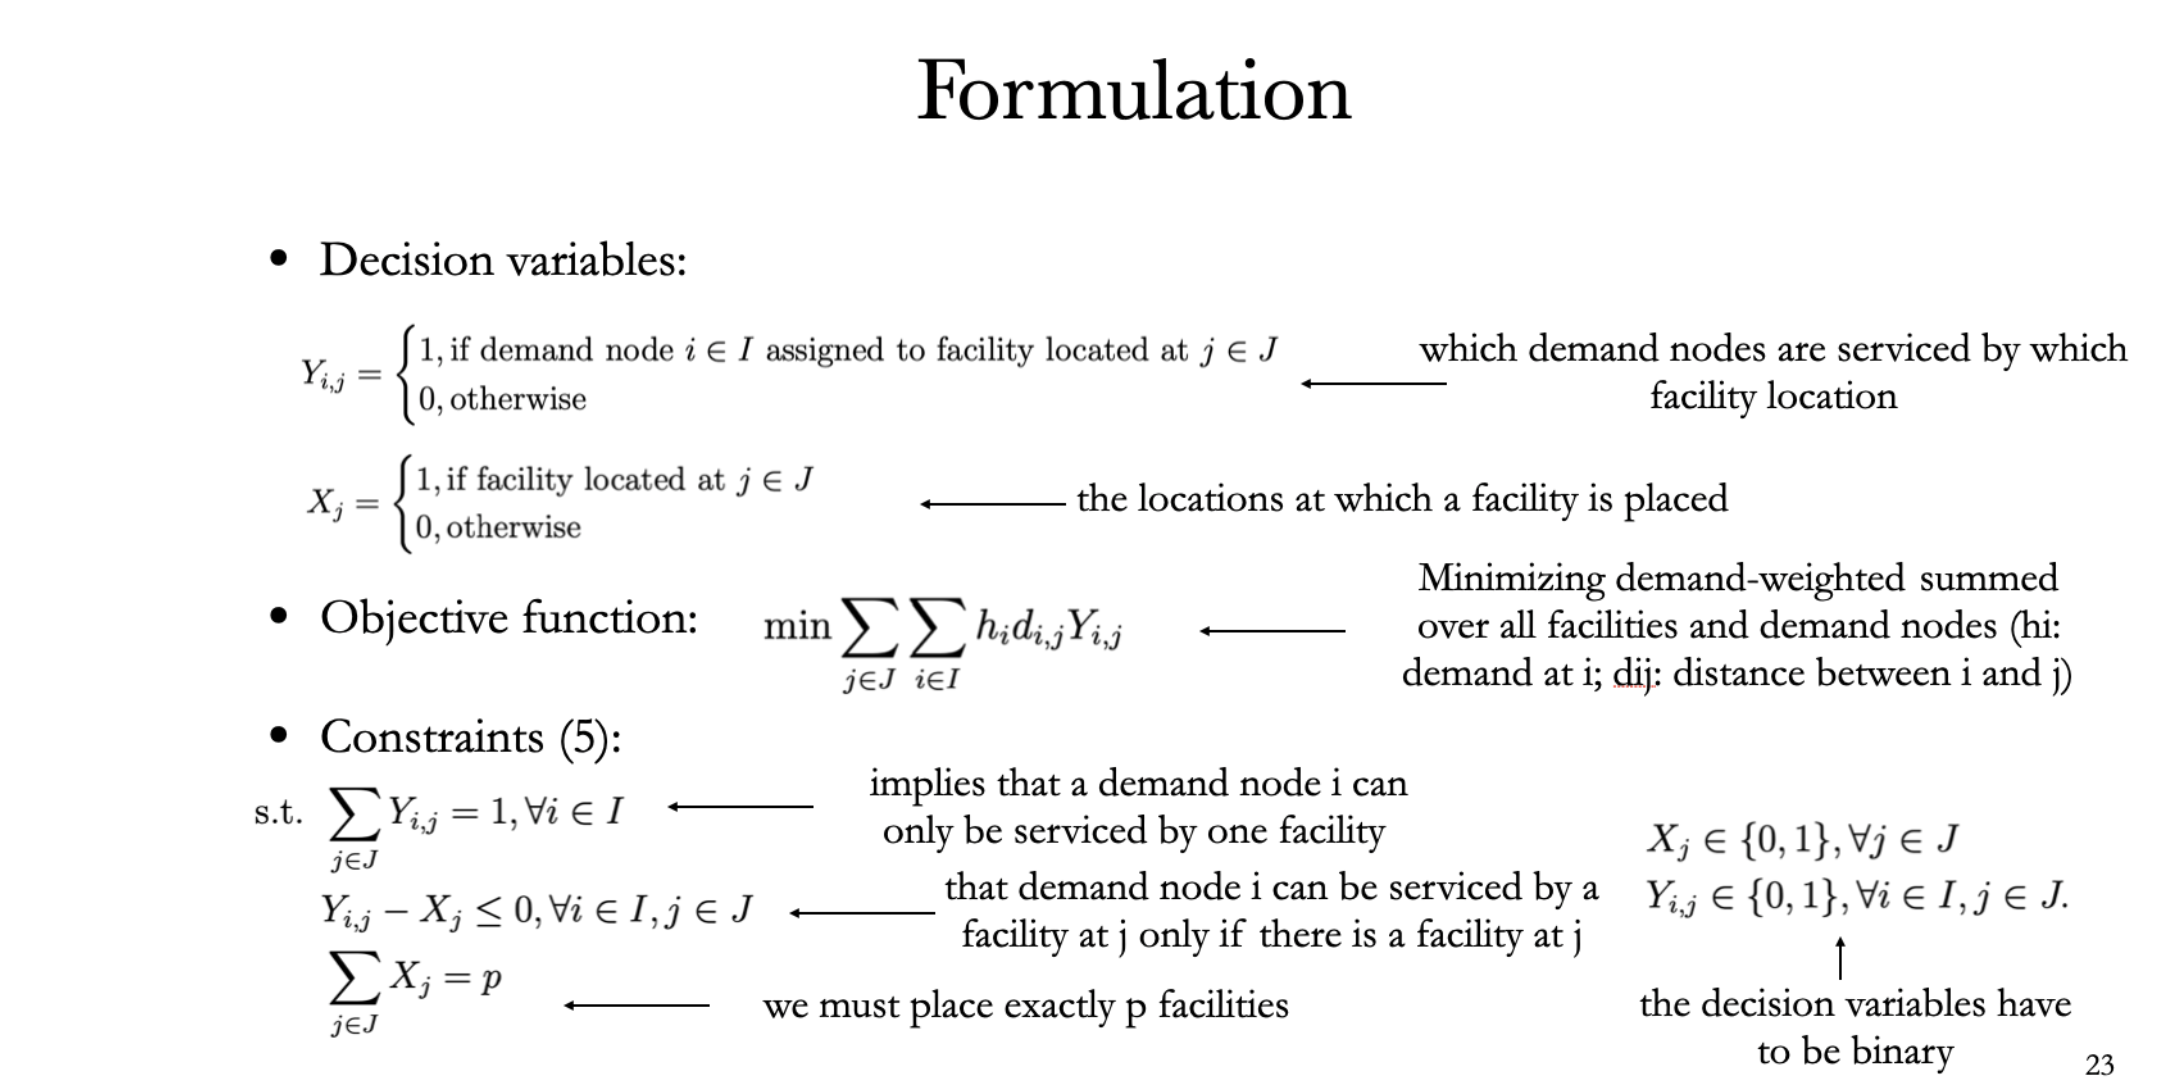

In [157]:
il = gpd.read_file('./data/chicago_comm_pop/chicago_comm_pop.shp')

In [158]:
il.head()

,GeoKey,Total_Pop,geometry
0,35,18238,"POLYGON ((-9752604.951 5137743.450, -9752605.8..."
1,36,5918,"POLYGON ((-9750713.852 5133595.674, -9750731.1..."
2,37,2876,"POLYGON ((-9754793.199 5131350.020, -9754792.7..."
3,38,21929,"POLYGON ((-9752334.139 5133578.410, -9752333.7..."
4,39,17841,"POLYGON ((-9750713.852 5133595.674, -9750713.4..."


In [175]:
#create demand and potential facility nodes
demand = np.arange(0,77,1)
facilities = np.arange(0,77,1)

In [176]:
#create a distance matrix
coords = list(zip(il.centroid.x,il.centroid.y))
d = cdist(coords,coords) 

In [177]:
#here we use demand as the total population
h = il.Total_Pop.values

In [178]:
# declare facilities variables
X = LpVariable.dicts('X_%s',(facilities),cat='Binary')

# declare demand-facility pair variables
Y = LpVariable.dicts('Y_%s_%s', (demand,facilities),cat='Binary')

let's assume that we stick to 5 departments - change *p* if you want to build more or less

In [260]:
p = 5

prob = LpProblem('P_Median', LpMinimize)

Objective function: Minimizing demand-distance weighted summed over all facilities and demand nodes 

h_i: demand at *i*; *d_ij*: distance between *i* and *j*

In [193]:
prob += sum(sum(h[i] * d[i][j] * Y[i][j] for j in facilities) for i in demand)

This constraint implies that a demand node *i* can only be serviced by one facility

In [195]:
for i in demand: 
    prob += sum(Y[i][j] for j in facilities) == 1

This constraint implies that that demand node *i* can be serviced by a facility at *j* only if there is a facility at *j*. It implicitly removes situation when node *i* is served by *j* but there is no facility at *j*. 

In [196]:
for i in demand:
    for j in facilities: 
        prob +=  Y[i][j] <= X[j]

In [197]:
%%time

prob.solve()

print("Status:", LpStatus[prob.status])

Status: Optimal
CPU times: user 141 ms, sys: 44.7 ms, total: 186 ms
Wall time: 530 ms


In [198]:
rslt=[]
for v in prob.variables():
    subV = v.name.split('_')
    
    if subV[0] == "X" and v.varValue == 1: 
        rslt.append(int(subV[1]))
        print('Facility Node: ', subV[1])

Facility Node:  18
Facility Node:  24
Facility Node:  39
Facility Node:  5
Facility Node:  60


In [199]:
fac_loc = il.iloc[rslt,:]

<AxesSubplot:>

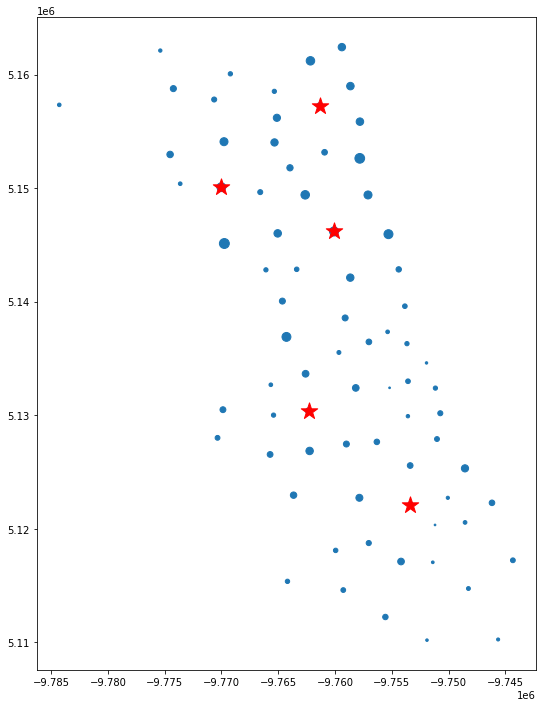

In [263]:
fig, ax = plt.subplots(figsize=(12,12))

il.centroid.plot(ax=ax,markersize=il.Total_Pop/1000)#markersize is proportional to the population
fac_loc.centroid.plot(ax=ax,color="red",markersize=300,marker="*")

In [201]:
from shapely.geometry import LineString, MultiLineString
lines = []
for v in prob.variables():
    subV = v.name.split('_')
    if subV[0] == "Y" and v.varValue == 1: 
        left, right = (int(subV[1]), int(subV[2]))
        line = LineString([il.iloc[left,:].geometry.centroid, il.iloc[right,:].geometry.centroid])
        lines.append(line)
gdf_lines = gpd.GeoDataFrame(geometry=lines)

(-9791764.037241032, -9740827.057254149, 5105054.073132936, 5167258.616755508)

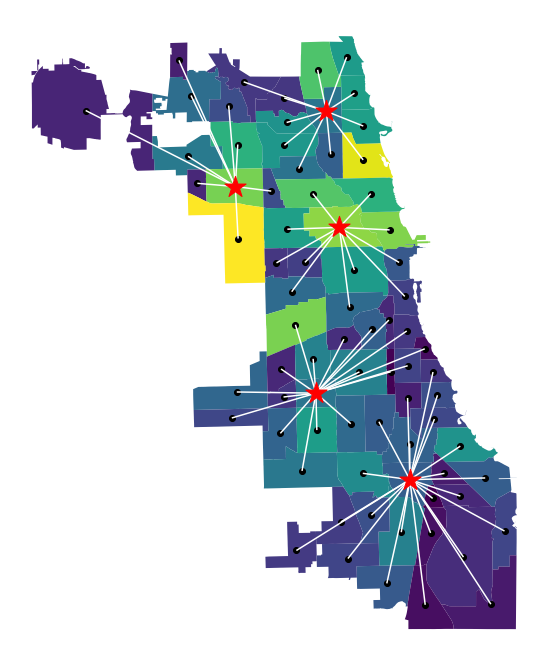

In [264]:
fig, ax = plt.subplots(figsize=(12,12))

il.plot(ax=ax,column="Total_Pop") # markersize is proportional to the population
il.centroid.plot(ax=ax,color="black")
gdf_lines.plot(ax=ax,color="white")
fac_loc.centroid.plot(ax=ax,color="red",markersize=500,marker="*",zorder=2)
plt.axis('off')